## Linear Regression with a Real Dataset


In [1]:
# Import relevant modules
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

### Information about dataset
[California Housing Data Set Description
](https://developers.google.com/machine-learning/crash-course/california-housing-data-description)

In [2]:
# Import the dataset.
training_df = pd.read_csv(filepath_or_buffer="california_housing_train.csv")

In [3]:
# Descriptive statistics of dataset
"""
count, which is the number of rows in that column. Ideally, count contains the same value for every column.

mean and std, which contain the mean and standard deviation of the values in each column.

min and max, which contain the lowest and highest values in each column.

25%, 50%, 75%, which contain various quantiles.
"""
training_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [4]:
# First 5 rows
training_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


In [5]:
# Scale the label.
"""
Scaling median_house_value puts the value of each house in units of thousands. 
Scaling will keep loss values and learning rates in a friendlier range.
Although scaling a label is usually not essential, scaling features in a multi-feature model usually is essential.
"""
training_df["median_house_value"] /= 1000.0

<h3> Task 1 - Identify anomalies in the dataset</h3>
<p>The maximum value (max) of several columns seems veryc
high compared to the other quantiles. For example,
 example the total_rooms column. Given the quantile
 values (25%, 50%, and 75%), you might expect the 
 max value of total_rooms to be approximately 
 5,000 or possibly 10,000. However, the max value 
 is actually 37,937.</p>

<p>When you see anomalies in a column, become more careful
 about using that column as a feature. That said,
 anomalies in potential features sometimes mirror 
 anomalies in the label, which could make the column 
 be (or seem to be) a powerful feature.
 Also, as you will see later in the course, you 
 might be able to represent (pre-process) raw data 
 in order to make columns into useful features.</p>

### Define the functions that build and train a model

In [7]:
def build_model(my_learning_rate):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Describe the topography of the model.
  # The topography of a simple linear regression model
  # is a single node in a single layer.
  model.add(tf.keras.layers.Dense(units=1, 
                                  input_shape=(1,)))

  # Compile the model topography into code that TensorFlow can efficiently
  # execute. Configure training to minimize the model's mean squared error. 
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model        


def train_model(model, df, feature, label, epochs, batch_size):
  """Train the model by feeding it data."""

  # Feed the model the feature and the label.
  # The model will train for the specified number of epochs. 
  history = model.fit(x=df[feature],
                      y=df[label],
                      batch_size=batch_size,
                      epochs=epochs)

  # Gather the trained model's weight and bias.
  trained_weights = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # Isolate the error for each epoch.
  hist = pd.DataFrame(history.history)

  # To track the progression of training, we're going to take a snapshot
  # of the model's root mean squared error at each epoch. 
  rmse = hist["root_mean_squared_error"]

  return trained_weights, trained_bias, epochs, rmse

print("Defined the create_model and traing_model functions.")

Defined the create_model and traing_model functions.


In [8]:
# Define the plotting functions
def plot_the_model(trained_weight, trained_bias, feature, label):
  """Plot the trained model against 200 random training examples."""

  # Label the axes.
  plt.xlabel(feature)
  plt.ylabel(label)

  # Create a scatter plot from 200 random points of the dataset.
  random_examples = training_df.sample(n=200)
  plt.scatter(random_examples[feature], random_examples[label])

  # Create a red line representing the model. The red line starts
  # at coordinates (x0, y0) and ends at coordinates (x1, y1).
  x0 = 0
  y0 = trained_bias
  x1 = 10000
  y1 = trained_bias + (trained_weight * x1)
  plt.plot([x0, x1], [y0, y1], c='r')

  # Render the scatter plot and the red line.
  plt.show()


def plot_the_loss_curve(epochs, rmse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()  

print("Defined the plot_the_model and plot_the_loss_curve functions.")

Defined the plot_the_model and plot_the_loss_curve functions.


### Call the model functions

Train on 17000 samples
Epoch 1/30
17000/17000 [==============================] - 2s 105us/sample - loss: 2838988.7289 - root_mean_squared_error: 1684.9298
Epoch 2/30
17000/17000 [==============================] - 1s 85us/sample - loss: 27587.9995 - root_mean_squared_error: 166.0964
Epoch 3/30
17000/17000 [==============================] - 1s 84us/sample - loss: 27134.6906 - root_mean_squared_error: 164.7262
Epoch 4/30
17000/17000 [==============================] - 1s 84us/sample - loss: 26344.5178 - root_mean_squared_error: 162.3099
Epoch 5/30
17000/17000 [==============================] - 1s 84us/sample - loss: 25525.1022 - root_mean_squared_error: 159.7658
Epoch 6/30
17000/17000 [==============================] - 1s 84us/sample - loss: 25045.4591 - root_mean_squared_error: 158.2576
Epoch 7/30
17000/17000 [==============================] - 1s 86us/sample - loss: 24308.8835 - root_mean_squared_error: 155.9131
Epoch 8/30
17000/17000 [==============================] - 1s 84us/sample - lo

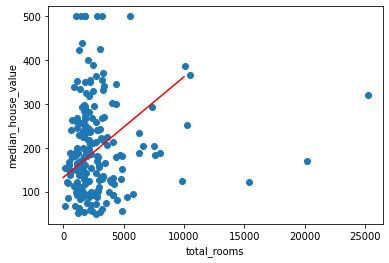

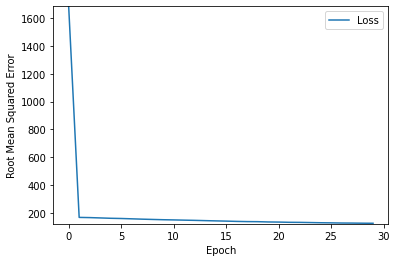

In [9]:
# Task 2
# The following variables are the hyperparameters.
learning_rate = 0.01
epochs = 30
batch_size = 30

# Specify the feature and the label.
my_feature = "total_rooms"  # the total number of rooms on a specific city block.
my_label="median_house_value" # the median value of a house on a specific city block.
# That is, you're going to create a model that predicts house value based 
# solely on total_rooms.  

# Discard any pre-existing version of the model.
my_model = None

# Invoke the functions.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df, 
                                         my_feature, my_label,
                                         epochs, batch_size)

print("\nThe learned weight for your model is %.4f" % weight)
print("The learned bias for your model is %.4f\n" % bias )

plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

### Use the model to make predictions

In [11]:
# house prediction function
def predict_house_values(n, feature, label):
  """Predict house values based on a feature."""

  batch = training_df[feature][10000:10000 + n]
  predicted_values = my_model.predict_on_batch(x=batch)

  print("feature   label          predicted")
  print("  value   value          value")
  print("          in thousand$   in thousand$")
  print("--------------------------------------")
  for i in range(n):
    print ("%5.0f %6.0f %15.0f" % (training_df[feature][i],
                                   training_df[label][i],
                                   predicted_values[i][0] ))

In [12]:
# invoke the house prediction function on 10 examples
predict_house_values(10, my_feature, my_label)

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
 5612     67             177
 7650     80             210
  720     86             217
 1501     73             183
 1454     66             188
 1387     74             262
 2907     82             209
  812     48             191
 4789     58             164
 1497     48             212


<p>Comment to results</p>
<p>
Most of the predicted values differ significantly
from the label value, so the trained model probably 
doesn't have much predictive power. However, the
first 10 examples might not be representative of 
the rest of the examples.  

The total_rooms feature had only a little predictive power. 
Would a different feature have greater predictive power?
Try using population as the feature instead of total_rooms.
</p>

Train on 17000 samples
Epoch 1/18
17000/17000 [==============================] - 33s 2ms/sample - loss: 28894.7616 - root_mean_squared_error: 169.9847
Epoch 2/18
17000/17000 [==============================] - 34s 2ms/sample - loss: 19912.6514 - root_mean_squared_error: 141.1122
Epoch 3/18
17000/17000 [==============================] - 36s 2ms/sample - loss: 18366.6378 - root_mean_squared_error: 135.5236
Epoch 4/18
17000/17000 [==============================] - 27s 2ms/sample - loss: 18059.2017 - root_mean_squared_error: 134.3845
Epoch 5/18
17000/17000 [==============================] - 26s 2ms/sample - loss: 18415.3682 - root_mean_squared_error: 135.7033
Epoch 6/18
17000/17000 [==============================] - 37s 2ms/sample - loss: 18072.2075 - root_mean_squared_error: 134.4328
Epoch 7/18
17000/17000 [==============================] - 34s 2ms/sample - loss: 18401.4089 - root_mean_squared_error: 135.6517
Epoch 8/18
17000/17000 [==============================] - 37s 2ms/sample - loss: 

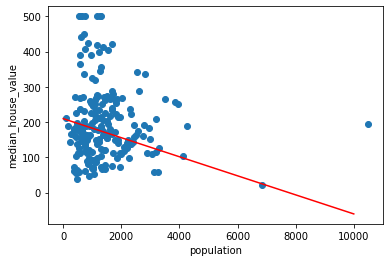

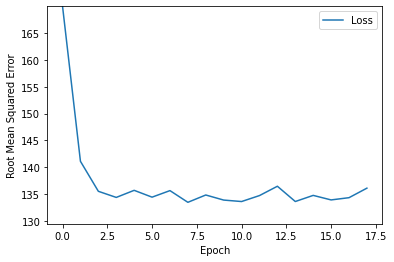

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
 1015     67             175
 1129     80             159
  333     86             151
  515     73             181
  624     66             165
  671     74             147
 1841     82             166
  375     48             181
 3134     58             201
  787     48             166


In [15]:
# Task 3 - use 'population' as a feature, but with different hyperparameters
my_feature = "population" # Pick a feature other than "total_rooms"

# Possibly, experiment with the hyperparameters.
learning_rate = 0.05
epochs = 18
batch_size = 3

# Don't change anything below.
my_model = build_model(learning_rate)
weight, bias, epochs, rmse = train_model(my_model, training_df, 
                                         my_feature, my_label,
                                         epochs, batch_size)

plot_the_model(weight, bias, my_feature, my_label)
plot_the_loss_curve(epochs, rmse)

predict_house_values(10, my_feature, my_label)

<p>Comment to results</p>
<p>Training is not entirely deterministic, but population 
typically converges at a slightly higher RMSE than 
total_rooms.  So, population appears to be about 
the same or slightly worse at making predictions 
than total_rooms.</p>
<p>You have determined that total_rooms and population were not useful features. That is, neither the total number of rooms in a neighborhood nor the neighborhood's population successfully predicted the median house price of that neighborhood. Perhaps though, the ratio of total_rooms to population might have some predictive power. That is, perhaps block density relates to median house value.</p>

Train on 17000 samples
Epoch 1/24
17000/17000 [==============================] - 4s 230us/sample - loss: 37977.4624 - root_mean_squared_error: 194.8781
Epoch 2/24
17000/17000 [==============================] - 3s 194us/sample - loss: 18778.3859 - root_mean_squared_error: 137.0343
Epoch 3/24
17000/17000 [==============================] - 4s 208us/sample - loss: 15254.9756 - root_mean_squared_error: 123.5110
Epoch 4/24
17000/17000 [==============================] - 3s 200us/sample - loss: 14904.7573 - root_mean_squared_error: 122.0850
Epoch 5/24
17000/17000 [==============================] - 3s 194us/sample - loss: 14697.6265 - root_mean_squared_error: 121.2338
Epoch 6/24
17000/17000 [==============================] - 3s 200us/sample - loss: 14559.2741 - root_mean_squared_error: 120.6619
Epoch 7/24
17000/17000 [==============================] - 3s 196us/sample - loss: 14331.9117 - root_mean_squared_error: 119.7160
Epoch 8/24
17000/17000 [==============================] - 4s 235us/sample 

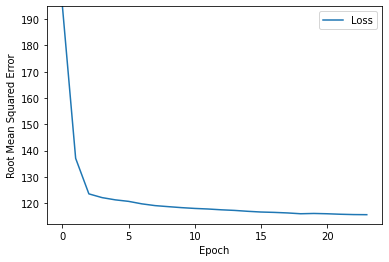

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
    6     67             190
    7     80             202
    2     86             196
    3     73             213
    2     66             188
    2     74             226
    2     82             212
    2     48             224
    2     58             289
    2     48             215
    2     86             225
    2     62             236
    2     49             226
    2     70             220
    2     45             212


In [16]:
# Task 4 - Define a synthetic feature
training_df["rooms_per_person"] = training_df["total_rooms"] / training_df["population"]
my_feature = "rooms_per_person"

# Tune the hyperparameters.
learning_rate = 0.06
epochs = 24
batch_size = 30

# Don't change anything below this line.
my_model = build_model(learning_rate)
weight, bias, epochs, mae = train_model(my_model, training_df,
                                        my_feature, my_label,
                                        epochs, batch_size)

plot_the_loss_curve(epochs, mae)
predict_house_values(15, my_feature, my_label)

<p>Comment to results</p>
<p>Based on the loss values, this synthetic feature produces a better model than the individual features you tried in Task 2 and Task 3. However, the model still isn't creating great predictions.</p>

<h3> Task 5. Find feature(s) whose raw values correlate with the label</h3>

So far, we've relied on trial-and-error to identify possible features for the model.  Let's rely on statistics instead.

A **correlation matrix** indicates how each attribute's raw values relate to the other attributes' raw values. Correlation values have the following meanings:

  * `1.0`: perfect positive correlation; that is, when one attribute rises, the other attribute rises.
  * `-1.0`: perfect negative correlation; that is, when one attribute rises, the other attribute falls. 
  * `0.0`: no correlation; the two column's [are not linearly related](https://en.wikipedia.org/wiki/Correlation_and_dependence#/media/File:Correlation_examples2.svg).

In general, the higher the absolute value of a correlation value, the greater its predictive power. For example, a correlation value of -0.8 implies far more predictive power than a correlation of -0.2.

The following code cell generates the correlation matrix for attributes of the California Housing Dataset:

In [17]:
# Generate a correlation matrix.
training_df.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_person
longitude,1.000000,-0.925208,-0.114250,0.047010,0.071802,0.101674,0.059628,-0.015485,-0.044982,-0.077773
latitude,-0.925208,1.000000,0.016454,-0.038773,-0.069373,-0.111261,-0.074902,-0.080303,-0.144917,0.143017
housing_median_age,-0.114250,0.016454,1.000000,-0.360984,-0.320434,-0.295890,-0.302754,-0.115932,0.106758,-0.103655
total_rooms,0.047010,-0.038773,-0.360984,1.000000,0.928403,0.860170,0.919018,0.195383,0.130991,0.121001
total_bedrooms,0.071802,-0.069373,-0.320434,0.928403,1.000000,0.881169,0.980920,-0.013495,0.045783,0.047811
population,0.101674,-0.111261,-0.295890,0.860170,0.881169,1.000000,0.909247,-0.000638,-0.027850,-0.140277
households,0.059628,-0.074902,-0.302754,0.919018,0.980920,0.909247,1.000000,0.007644,0.061031,-0.034049
median_income,-0.015485,-0.080303,-0.115932,0.195383,-0.013495,-0.000638,0.007644,1.000000,0.691871,0.232667
median_house_value,-0.044982,-0.144917,0.106758,0.130991,0.045783,-0.027850,0.061031,0.691871,1.000000,0.206969
rooms_per_person,-0.077773,0.143017,-0.103655,0.121001,0.047811,-0.140277,-0.034049,0.232667,0.206969,1.000000


The correlation matrix shows nine potential features (including a synthetic feature) and one label (median_house_value). A strong negative correlation or strong positive correlation with the label suggests a potentially good feature.

Your Task: Determine which of the nine potential features appears to be the best candidate for a feature?

<p>The `median_income` correlates 0.7 with the label 
 (median_house_value), so median_income` might be a 
 good feature. The other seven potential features
 all have a correlation relatively close to 0.</p>

Train on 17000 samples
Epoch 1/24
17000/17000 [==============================] - 4s 226us/sample - loss: 27850.1075 - root_mean_squared_error: 166.8835
Epoch 2/24
17000/17000 [==============================] - 4s 219us/sample - loss: 7286.4801 - root_mean_squared_error: 85.3609
Epoch 3/24
17000/17000 [==============================] - 4s 220us/sample - loss: 7016.5671 - root_mean_squared_error: 83.7650
Epoch 4/24
17000/17000 [==============================] - 3s 178us/sample - loss: 7015.9585 - root_mean_squared_error: 83.7613
Epoch 5/24
17000/17000 [==============================] - 3s 185us/sample - loss: 7015.6594 - root_mean_squared_error: 83.7596
Epoch 6/24
17000/17000 [==============================] - 4s 243us/sample - loss: 7014.0145 - root_mean_squared_error: 83.7497
Epoch 7/24
17000/17000 [==============================] - 5s 310us/sample - loss: 7016.8946 - root_mean_squared_error: 83.7669
Epoch 8/24
17000/17000 [==============================] - 5s 307us/sample - loss: 7015

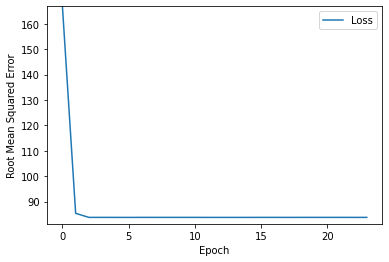

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
    1     67             134
    2     80             212
    2     86             154
    3     73             132
    2     66             153
    3     74             148
    3     82             457
    2     48             260
    2     58             147
    2     48             221
    3     86             397
    2     62             163
    2     49             179
    3     70             221
    1     45             143


In [18]:
# Task 6 - use 'median_income' as a feature, but with different hyperparameters
my_feature = "median_income"

# Tune the hyperparameters.
learning_rate = 0.06
epochs = 24
batch_size = 30

# Don't change anything below this line.
my_model = build_model(learning_rate)
weight, bias, epochs, mae = train_model(my_model, training_df,
                                        my_feature, my_label,
                                        epochs, batch_size)

plot_the_loss_curve(epochs, mae)
predict_house_values(15, my_feature, my_label)

<p>Correlation matrices don't tell the entire story. There are additional ways to unlock predictive power from potential features - later.</p>